# Data Analysis on Heart Disease

## Introduction
One of the leading causes of death in the world and the leading cause in the United States, is heart disease and has been for many years. With the rate of them increasing worldwide in recent years, it is important to look at the leading causes of this disease and establish a relationship between them and its global increase. As a base for our analysis we are going to use the heart disease dataset available at Kaggle.

The dataset originates from 1988 and evaluates data from four different databases: Cleveland, Hungary, Switzerland and Long Beach V. While the dataset does have 76 distinct attributes, it only utilizes 14 of them. 

**Predictive question:**
How does the amount of cholesterol, type of heart defect, age, and sex help us predict the diagnosis of heart disease?


In [13]:
### Run this cell before continuing.

library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 10)

**Reading the Data**

First read the raw data from GitHub that we uploaded.

In [6]:
heart_disease_data <- read_csv("https://raw.githubusercontent.com/yma24ma/dsci_009_43_gp/main/heart.csv")
heart_disease_data

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0


**Variables**

age: Age

sex: Sex

cp: Chest pain type (4 values)

trestbps: resting blood pressure

chol: serum cholestoral in mg/dl

fbs: fasting blood sugar > 120 mg/dl

restecg: resting electrocardiographic results (values 0,1,2)

thalacg: maximum heart rate achieved

exang: exercise induced angina

oldpeak: ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

ca: number of major vessels (0-3) colored by flourosopy

thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

target: diagnosis of heart disease

**Select Data**

We will now be using the `select()` function to select the row that we will be using in this analysis and make it into one table.

In [59]:
heart_disease_selected <- select(heart_disease_data, age, sex, fbs, exang, chol, target,thalach)|>
                        mutate(sex=as_factor(sex))|>
                        mutate(fbs=as_factor(fbs))|>
                        mutate(exang=as_factor(exang))|>
                        mutate(target=as_factor(target))
heart_disease_selected

age,sex,fbs,exang,chol,target,thalach
<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>
52,1,0,0,212,0,168
53,1,1,1,203,0,155
70,1,0,1,174,0,125
61,1,0,0,203,0,161
62,0,1,0,294,0,106
⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,1,0,1,221,1,164
60,1,0,1,258,0,141
47,1,0,1,275,0,118


**Average of Selected**

In [53]:
hd_average1 <- heart_disease_selected |>
                map(mean) 
hd_average1

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


$age
[1] 54.43415

$sex
[1] NA

$fbs
[1] NA

$exang
[1] NA

$chol
[1] 246

$thal
[1] NA

$target
[1] NA

**Plot Sex X Target**

In [54]:
hd_sex_target_df <- heart_disease_selected |>
                        group_by(sex) |>
                        summarize(average_target = mean(target, na.rm = TRUE))
hd_sex_target_df

Warning message:
“There were 2 warnings in `summarize()`.
The first warning was:
ℹ In argument: `average_target = mean(target, na.rm = TRUE)`.
ℹ In group 1: `sex = 0`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


sex,average_target
<fct>,<dbl>
0,NA
1,NA


In [55]:
hd_agechol<-select(heart_disease_selected,age,chol,sex)
hd_agechol

age,chol,sex
<dbl>,<dbl>,<fct>
52,212,1
53,203,1
70,174,1
61,203,1
62,294,0
⋮,⋮,⋮
59,221,1
60,258,1
47,275,1


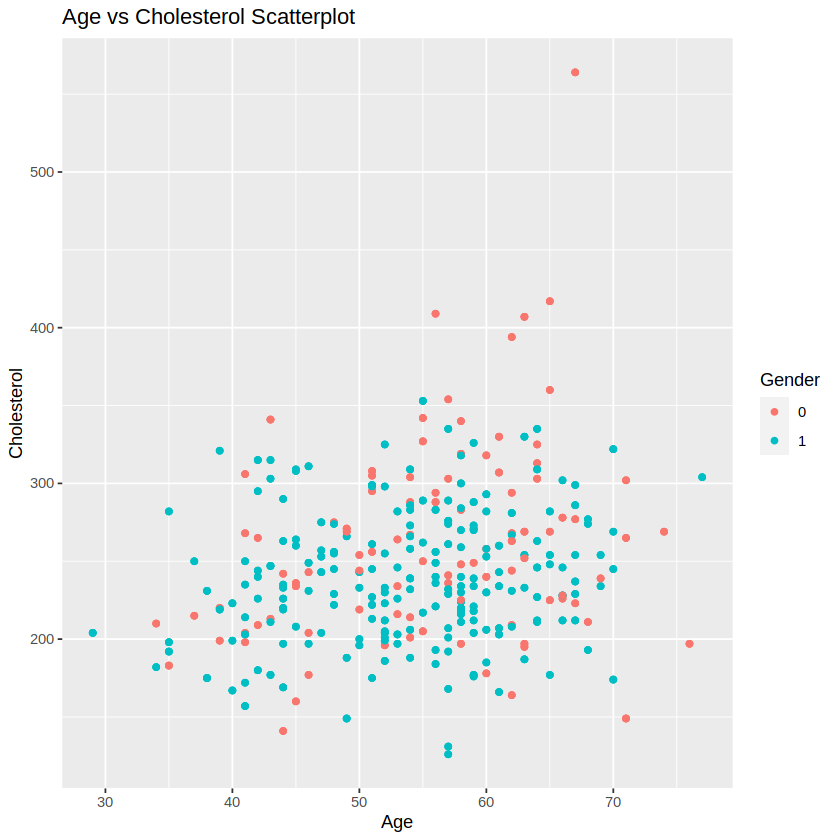

In [56]:
hd_agechol_plot<-ggplot(hd_agechol,aes(x=age,y=chol,colour=sex))+
                        geom_point()+
                        labs(x="Age",y="Cholesterol",colour="Gender")+
                        
                    ggtitle("Age vs Cholesterol Scatterplot")
hd_agechol_plot    

## Methods
For our Heart Disease data set, we are going to use the method of K-nearest neighbors classification. Essentially, we are going to use predictor variables chol (amount of cholesterol), thal (type of heart defect), age and sex to predict the diagnosis class of heart disease, which can be categorized into 0 (no heart disease) or 1 (heart disease). Therefore, the column names we will incorporate are chol, thal, age, sex and target. We chose to only use four predictor variables because we think that there are more than two factors that contribute to the diagnosis of heart disease. Since there are multivariables, we can avoid a 4D graph by using the facet_grid function to create a plot that has multiple subplots arranged in a grid.